# Program for automatically identifying defects in steel surfaces

In [29]:
import os
import torchvision
import matplotlib.pyplot as plt
from torch.utils.data import random_split, TensorDataset, DataLoader
import torch.nn as nn
import torch
import torchvision.models as models
from sklearn.metrics import ConfusionMatrixDisplay

In [30]:
from detector.read_data import read_data
from detector.write_wrong_detections import write_wrong_detections
from detector.model_manual_AlexNET import AlexNET_based
from detector.model_manual_inception import inception_Network_based, inception_block
from detector.model_manual_ResNET import ResNET_based, ResidualBlock
from detector.model_small_conv import conv_network

1. Check if Cuda is available

In [31]:
print("Cuda available: ", torch.cuda.is_available())
print("Cuda device:", torch.cuda.get_device_name(0))

Cuda available:  True
Cuda device: NVIDIA GeForce RTX 3050 Ti Laptop GPU


2. Path to the Data

In [32]:
curr_path = os.path.abspath('..')
data_subdir_path = "\\Dataset-trafo\\"
data_path = curr_path + data_subdir_path
sample_image = torchvision.io.read_image(data_path + "good\\" + "10000.png")
print(sample_image.size())
print(data_path)

torch.Size([3, 645, 229])
c:\Users\Admin\Desktop\for_review\surface_defects\Dataset-trafo\


3. Show test image

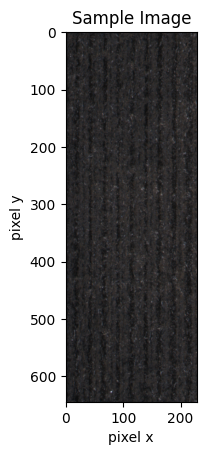

In [33]:
plt.imshow(sample_image.permute(1, 2, 0))
plt.title(label="Sample Image")
plt.xlabel(xlabel="pixel x")
plt.ylabel(ylabel="pixel y")
plt.show()

4. Test of flip function on test image

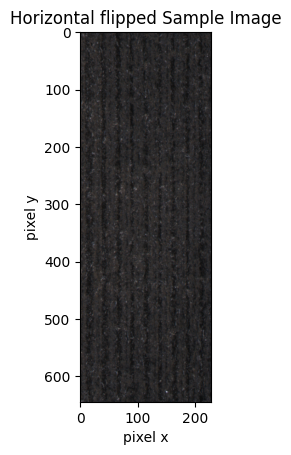

In [34]:
sample_flipped = torchvision.transforms.functional.hflip(sample_image)
plt.imshow(sample_flipped.permute(1, 2, 0))
plt.title(label="Horizontal flipped Sample Image")
plt.xlabel(xlabel="pixel x")
plt.ylabel(ylabel="pixel y")
plt.show()

5. Creating x_batch, y_batch from images in data_path

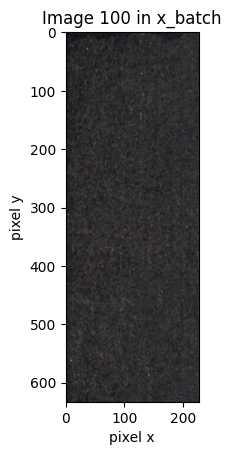

X_batch_size: torch.Size([1836, 3, 633, 228])


In [35]:
x_values, y_values, df1 = read_data(data_path=data_path)
plt.imshow(x_values[100].permute(1, 2, 0))
plt.title(label="Image 100 in x_batch")
plt.xlabel(xlabel="pixel x")
plt.ylabel(ylabel="pixel y")
plt.show()
print("X_batch_size:", x_values.size())

6. Plotting histogram of labels to get insides in the distribution

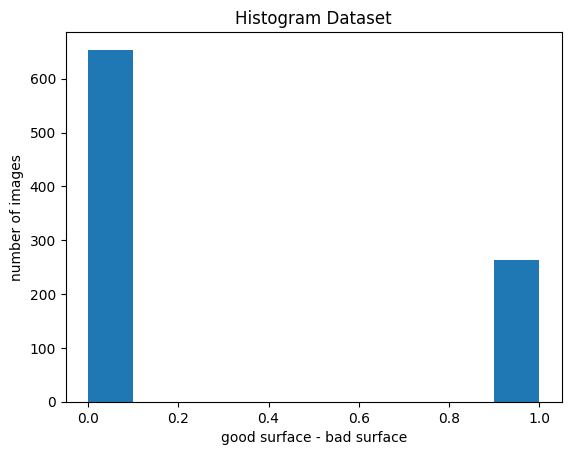

In [36]:
plt.hist(df1["label"])
plt.title(label="Histogram Dataset")
plt.xlabel(xlabel="good surface - bad surface")
plt.ylabel(ylabel="number of images")
plt.show()

7. Seperation in train and test set

In [37]:
train_set_size = 0.9
ds = TensorDataset(x_values, y_values)
len_train_ds = int(len(x_values) * train_set_size)
len_test_ds = len(x_values) - len_train_ds
train_ds, test_ds = random_split(
    ds, [len_train_ds, len_test_ds]
)

8. Dataloader for train set

In [38]:
batch_size = 24
torch.manual_seed(1)
train_dl = DataLoader(train_ds, batch_size, shuffle=True)

9. Model selection by removing "#"; best perfomance: models.resnet.ResNet with 30-40 Epochs

In [39]:
model = models.resnet.ResNet(models.resnet.BasicBlock, [2, 2, 2, 2], num_classes=2)
# model=models.mobilenet.mobilenet_v3_small(num_classes=2)
# model=AlexNET_based()
# model=conv_network()
# model=inception_Network_based(inception_block=inception_block)
# model=ResNET_based(Residualblock=ResidualBlock, num_block1=2, num_block2=2, num_block3=2)

10. Training Loop (here without learning rate decay)

In [40]:
model = model.cuda()
loss_fn = nn.CrossEntropyLoss()
torch.manual_seed(42)
accuray_array = []
num_epochs = 30

for epoch in range(num_epochs):
    optimizer = torch.optim.Adam(
        params=model.parameters(), lr=0.001
    )
    accuracy_hist_train = 0
    for x_batch, y_batch in train_dl:
        x_batch = x_batch.cuda()
        y_batch = y_batch.cuda()
        pred = model(x_batch)
        loss = loss_fn(pred, y_batch)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        is_correct = (torch.argmax(pred, dim=1) == y_batch).float()
        accuracy_hist_train += is_correct.sum()
        torch.cuda.empty_cache()
    accuracy_hist_train /= len(train_dl.dataset)
    print(f"Epoch {epoch} Accuracy " f"{accuracy_hist_train:.4f}")
    torch.cuda.empty_cache()

Epoch 0 Accuracy 0.8898
Epoch 1 Accuracy 0.9183
Epoch 2 Accuracy 0.9177
Epoch 3 Accuracy 0.9377
Epoch 4 Accuracy 0.9407
Epoch 5 Accuracy 0.9449
Epoch 6 Accuracy 0.9516
Epoch 7 Accuracy 0.9377
Epoch 8 Accuracy 0.9570
Epoch 9 Accuracy 0.9564
Epoch 10 Accuracy 0.9607
Epoch 11 Accuracy 0.9679
Epoch 12 Accuracy 0.9685
Epoch 13 Accuracy 0.9661
Epoch 14 Accuracy 0.9722
Epoch 15 Accuracy 0.9715
Epoch 16 Accuracy 0.9673
Epoch 17 Accuracy 0.9806
Epoch 18 Accuracy 0.9861
Epoch 19 Accuracy 0.9879
Epoch 20 Accuracy 0.9879
Epoch 21 Accuracy 0.9897
Epoch 22 Accuracy 0.9885
Epoch 23 Accuracy 0.9879
Epoch 24 Accuracy 0.9897
Epoch 25 Accuracy 0.9903
Epoch 26 Accuracy 0.9933
Epoch 27 Accuracy 0.9879
Epoch 28 Accuracy 0.9952
Epoch 29 Accuracy 0.9927


11. Accuracy on test set

In [41]:
x_test, y_test = test_ds[:]
with torch.no_grad():
    model = model.cpu()
    pred = model(x_test)
is_correct = (torch.argmax(pred, dim=1) == y_test).float()
print(f"Test accuracy: {is_correct.mean():.4f}")

Test accuracy: 0.9946


12. Show Confusion Matrix on test set

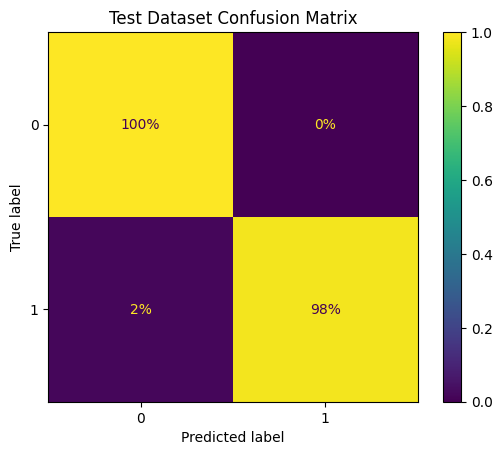

In [42]:
pred_single_values = torch.argmax(pred, dim=1)
pred_numpy = pred_single_values.detach().numpy()
y_test.numpy()
ConfusionMatrixDisplay.from_predictions(
    y_test, pred_numpy, normalize="true", values_format=".0%"
)
plt.title("Test Dataset Confusion Matrix")
plt.show()

13. Writing wrong detections to folders for further inspection

In [43]:
write_wrong_detections(
    data_path=data_path, x_test=x_test, y_test=y_test, is_correct=is_correct
)

14. Save model

In [44]:
if not (os.path.isdir(curr_path + "\\model_parameters")):
    os.mkdir(path=curr_path + "\\model_parameters")
torch.save(model, curr_path + "\\model_parameters\\model.md")